# Additional analyses for manuscript revisions
This notebook contains additional analyses performed for a revised version of the manuscript. In particular, two analyses are performed:
1. Determining whether there is a bias in the linear arrangement of motifs in strong enhancers and silencers.
2. Associating differentially expressed genes in Crx-/- vs. wildtype P21 retinas with the activity of nearby library members.

In [1]:
import os
import sys
import itertools

import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from pybedtools import BedTool
from IPython.display import display

sys.path.insert(0, "utils")
import fasta_seq_parse_manip, modeling, plot_utils, predicted_occupancy, sequence_annotation_processing

data_dir = "Data"
downloads_dir = os.path.join(data_dir, "Downloaded")
figures_dir = "Figures"
all_seqs = fasta_seq_parse_manip.read_fasta(os.path.join(data_dir, "library1And2.fasta"))
# Drop scrambled sequences
all_seqs = all_seqs[~(all_seqs.index.str.contains("scr"))]

In [2]:
plot_utils.set_manuscript_params()

Load in MPRA data and other metrics.

In [3]:
# Mapping activity class to a color
color_mapping = {
    "Silencer": "#e31a1c",
    "Inactive": "#33a02c",
    "Weak enhancer": "#a6cee3",
    "Strong enhancer": "#1f78b4",
    np.nan: "grey"
}
color_mapping = pd.Series(color_mapping)

# Sort order for the four activity bins
class_sort_order = ["Silencer", "Inactive", "Weak enhancer", "Strong enhancer"]

# MPRA measurements
activity_df = pd.read_csv(os.path.join(data_dir, "wildtypeMutantPolylinkerActivityAnnotated.txt"), sep="\t", index_col=0)
activity_df["group_name_WT"] = sequence_annotation_processing.to_categorical(activity_df["group_name_WT"])
activity_df["group_name_MUT"] = sequence_annotation_processing.to_categorical(activity_df["group_name_MUT"])
# Only keep sequences that were measured in WT form
activity_df = activity_df[activity_df["expression_log2_WT"].notna()]

# TF occupancy metrics, also separate out the WT sequences
occupancy_df = pd.read_csv(os.path.join(data_dir, "predictedOccupancies.txt"), sep="\t", index_col=0)
wt_occupancy_df = occupancy_df[occupancy_df.index.str.contains("WT$")].copy()
wt_occupancy_df = sequence_annotation_processing.remove_mutations_from_seq_id(wt_occupancy_df)
wt_occupancy_df = wt_occupancy_df.loc[activity_df.index]
n_tfs = len(wt_occupancy_df.columns)

# PWMs
pwms = predicted_occupancy.read_pwm_files(os.path.join("Data", "Downloaded", "Pwm", "photoreceptorAndEnrichedMotifs.meme"))
pwms = pwms.rename(lambda x: x.split("_")[0])
motif_len = pwms.apply(len)
mu = 9
ewms = pwms.apply(predicted_occupancy.ewm_from_letter_prob).apply(predicted_occupancy.ewm_to_dict)

# WT sequences measured in the assay
wt_seqs = all_seqs[all_seqs.index.str.contains("WT")].copy()
wt_seqs = sequence_annotation_processing.remove_mutations_from_seq_id(wt_seqs)
wt_seqs = wt_seqs[activity_df.index]

## Analysis for linear arrangement bias
For each TF besides CRX, identify strong enhancers with exactly one position occupied by CRX and exactly one position occupied by the other TF. Count the number of times the occupied position is 5' (left) or 3' (right) of the CRX position. Because all sequences are centered on CRX motifs in a forward orientation, we do not need to consider orientation.

In [4]:
occupied_cutoff = 0.5
strong_mask = activity_df["group_name_WT"].str.contains("Strong")
strong_mask = strong_mask & strong_mask.notna()
# {tf name: [number of times TF is 5' of central CRX, number of times 3']}
tf_order_counts = {}

for tf in ewms.index.drop("CRX"):
    left_counts = right_counts = 0
    # Get strong enhancers with a motif for this TF
    has_tf_mask = (wt_occupancy_df[tf] > occupied_cutoff) & strong_mask
    has_tf_seqs = wt_seqs[has_tf_mask]
    # Get the predicted occupancy landscape only for CRX and the other TF
    for seq in has_tf_seqs:
        occupancy_landscape = predicted_occupancy.total_landscape(seq, ewms[["CRX", tf]], mu) > occupied_cutoff
        # Only consider the sequence if there is exactly one CRX and exactly one of the other TF
        fwd_counts = occupancy_landscape[tf + "_F"].sum()
        rev_counts = occupancy_landscape[tf + "_R"].sum()
        if (occupancy_landscape["CRX_F"].sum() == 1) and (occupancy_landscape["CRX_R"].sum() == 0) and (fwd_counts + rev_counts == 1):
            # By construction, the motif will only be in the F or R column
            if fwd_counts == 1:
                col = occupancy_landscape[tf + "_F"]
            else:
                col = occupancy_landscape[tf + "_R"]
            
            tf_start_pos = col[col].index[0]
            # CRX start position should always be the same, but just in case it's not do this
            crx_occ = occupancy_landscape["CRX_F"]
            crx_start_pos = crx_occ[crx_occ].index[0]
            if tf_start_pos < crx_start_pos:
                left_counts += 1
            elif tf_start_pos > crx_start_pos:
                right_counts += 1
            # else they start at the same position, ignore it
            
    tf_order_counts[tf] = [left_counts, right_counts]
    
tf_order_counts = pd.DataFrame.from_dict(tf_order_counts, orient="index", columns=["left", "right"])
tf_order_counts["binom_pval"] = tf_order_counts.apply(stats.binom_test, axis=1)
tf_order_counts["binom_qval"] = modeling.fdr(tf_order_counts["binom_pval"])
display(tf_order_counts)

,left,right,binom_pval,binom_qval
GFI1,8,10,0.814529,0.814529
MAZ,13,25,0.072951,0.255330
MEF2D,7,3,0.343750,0.802083
NDF1,17,22,0.522397,0.609464
NRL,14,31,0.016094,0.112661
RORB,14,20,0.391528,0.548140
RAX,8,4,0.387695,0.678467


Now do the same analyses as above for silencers with NRL. Then create a contingency table to determine whether the left/right positioning of NRL motifs is independent of whether a sequence is a strong enhancer or silencer.

In [5]:
silencer_mask = activity_df["group_name_WT"].str.contains("Silencer")
silencer_mask = silencer_mask & silencer_mask.notna()
has_nrl_mask = (wt_occupancy_df["NRL"] > occupied_cutoff) & silencer_mask
has_nrl_seqs = wt_seqs[has_nrl_mask]

silencer_left_counts = silencer_right_counts = 0
for seq in has_nrl_seqs:
    occupancy_landscape = predicted_occupancy.total_landscape(seq, ewms[["CRX", "NRL"]], mu) > occupied_cutoff
    # Only consider the sequence if there is exactly one CRX and exactly one of the other TF
    fwd_counts = occupancy_landscape["NRL_F"].sum()
    rev_counts = occupancy_landscape["NRL_R"].sum()
    if (occupancy_landscape["CRX_F"].sum() == 1) & (occupancy_landscape["CRX_R"].sum() == 0) & (fwd_counts + rev_counts == 1):
        # Samw as above
        if fwd_counts == 1:
            col = occupancy_landscape["NRL_F"]
        else:
            col = occupancy_landscape["NRL_R"]

        tf_start_pos = col[col].index[0]
        crx_occ = occupancy_landscape["CRX_F"]
        crx_start_pos = crx_occ[crx_occ].index[0]
        if tf_start_pos < crx_start_pos:
            silencer_left_counts += 1
        elif tf_start_pos > crx_start_pos:
            silencer_right_counts += 1

silencer_order_counts = pd.Series([silencer_left_counts, silencer_right_counts], index=["left", "right"])
# Join with strong enhancer counts
contingency_table = pd.DataFrame.from_dict({"Silencer": silencer_order_counts, "Strong enhancer": tf_order_counts.loc["NRL", ["left", "right"]]}, orient="index").astype(int)
display(contingency_table)
odds, pval = stats.fisher_exact(contingency_table)
print(f"The linear arrangement of CRX-NRL motifs is independent of whether a sequence is a strong enhancer or silencer, Fisher's exact test p={pval:.2f}, odds ratio={odds:.1f}")

,left,right
Silencer,6,5
Strong enhancer,14,31


The linear arrangement of CRX-NRL motifs is independent of whether a sequence is a strong enhancer or silencer, Fisher's exact test p=0.17, odds ratio=2.7


## Analysis of gene expression changes in Crx-/- retina
First, read in the RNA-seq data, CPM normalize each replicate, compute mean expression across replicates, and then compute the fold changes between Crx-/- and WT.

In [6]:
rnaseq_df = pd.read_csv(os.path.join(downloads_dir, "rogerRnaseqRaw2014.txt"), sep="\t", usecols=["Wta", "Wtb", "Crxa", "Crxb"])
# Add a pseudocount too when CPM normalizing
rnaseq_df = (rnaseq_df + 1) / (rnaseq_df.sum() / 1e6)
# Compute averages and then log2 FC
ko_wt_fc_log2 = np.log2(rnaseq_df[["Crxa", "Crxb"]].mean(axis=1) / rnaseq_df[["Wta", "Wtb"]].mean(axis=1))

Next, read in a BED file of the library and intersect it with [Supplementary file 4](https://doi.org/10.7554/eLife.48216.022) from Murphy *et al.*, 2019 to associate sequences to genes.

In [7]:
bed_columns = ["chrom", "begin", "end", "label", "score", "strand"]
# Load in BED file
library_bed = pd.read_csv(os.path.join(data_dir, "library1And2.bed"), sep="\t", header=None, names=bed_columns)
# Pull out sequences that were measured
library_bed = library_bed.set_index("label").loc[activity_df.index].reset_index()[bed_columns]
library_bed = BedTool.from_dataframe(library_bed).sort()

# Read in ATAC data and intersect with the library
atac_df = pd.read_excel(os.path.join(downloads_dir, "murphyAtac2019.xlsx"), sheet_name="peakUnion_counts", skiprows=1)
atac_bed = BedTool.from_dataframe(atac_df[["Chr", "Start", "End", "PeakID"]]).sort()
atac_bed = atac_bed.intersect(library_bed, wo=True).to_dataframe()
atac_bed = atac_bed[["chrom", "start", "end", "name", "thickEnd"]].rename(columns={"thickEnd": "library_label"})
atac_df = atac_df.set_index("PeakID").loc[atac_bed["name"]].reset_index()
atac_df["library_label"] = atac_bed["library_label"]

Get the gene closest to every library member, and then get the fold change.

In [8]:
def get_nearest_gene_fc(gene):
    if gene in ko_wt_fc_log2.index:
        return ko_wt_fc_log2[gene]
    else:
        return np.nan
    
library_nearest_gene = atac_df.set_index("library_label")["Nearest Gene"]
library_gene_fc = library_nearest_gene.apply(get_nearest_gene_fc)
library_gene_fc = library_gene_fc[library_gene_fc.notna()]
activity_has_gene_df = activity_df.loc[library_gene_fc.index]

Now get genes that have an absolute fold change of 2 (log2 = 1) or more.

In [9]:
library_gene_de = library_gene_fc[library_gene_fc.abs() >= 1]
up_mask = (library_gene_de > 0).replace({False: "Down-regulated", True: "Up-regulated"})
de_direction_grouper = library_gene_de.groupby(up_mask)

Determine enrichment of silencers being near up-regulated genes and enhancers being near down-regulated genes.

Direction of differential expression is independent of having a silencer nearby, Fisher's exact test p=0.001, OR=2.13


,False,True
Nearest Gene,,
Down-regulated,0.866279,0.133721
Up-regulated,0.752427,0.247573


Direction of differential expression is independent of having an enhancer nearby, Fisher's exact test p=0.022, OR=1.52


,True,False
Nearest Gene,,
Down-regulated,0.680233,0.319767
Up-regulated,0.582524,0.417476


Text(0, 0.5, 'Fraction of genes near an enhancer')

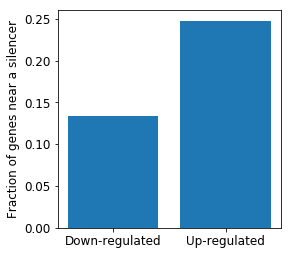

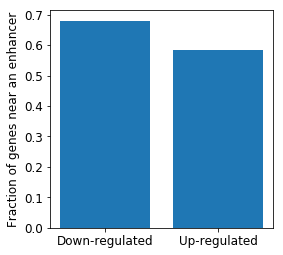

In [10]:
# Silencers
silencer_count_contingency = de_direction_grouper.apply(lambda x: activity_has_gene_df.loc[x.index, "group_name_WT"].str.contains("Silencer").value_counts()).unstack()
oddsratio, pval = stats.fisher_exact(silencer_count_contingency)
print(f"Direction of differential expression is independent of having a silencer nearby, Fisher's exact test p={pval:.3f}, OR={oddsratio:.2f}")

silencer_count_contingency = silencer_count_contingency.div(silencer_count_contingency.sum(axis=1), axis=0)
display(silencer_count_contingency)
fig, ax = plt.subplots()
ax.bar([0, 1], silencer_count_contingency[True], tick_label=silencer_count_contingency.index)
ax.set_ylabel("Fraction of genes near a silencer")

# Enhancers
enhancer_count_contingency = de_direction_grouper.apply(lambda x: activity_has_gene_df.loc[x.index, "group_name_WT"].str.contains("enhancer").value_counts()).unstack()
oddsratio, pval = stats.fisher_exact(enhancer_count_contingency)
print(f"Direction of differential expression is independent of having an enhancer nearby, Fisher's exact test p={pval:.3f}, OR={oddsratio:.2f}")

enhancer_count_contingency = enhancer_count_contingency.div(enhancer_count_contingency.sum(axis=1), axis=0)
display(enhancer_count_contingency)
fig, ax = plt.subplots()
ax.bar([0, 1], enhancer_count_contingency[True], tick_label=enhancer_count_contingency.index)
ax.set_ylabel("Fraction of genes near an enhancer")